In [1]:
from SpotAnnotationAnalysis import SpotAnnotationAnalysis
from BaseAnnotation import BaseAnnotation
from QuantiusAnnotation import QuantiusAnnotation
import math
import pandas as pd
import matplotlib.pyplot as plt

worker_marker_size = 8
cluster_marker_size = 40
bigger_window_size = True
img_height = 300
show_correctness = True
correctness_threshold = 4
clustering_params = ['AffinityPropagation', -350]

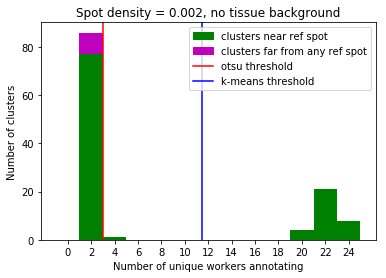

Using only clusters to the right of the k-means threshold:
TPR = 0.79
FPR = 0.06


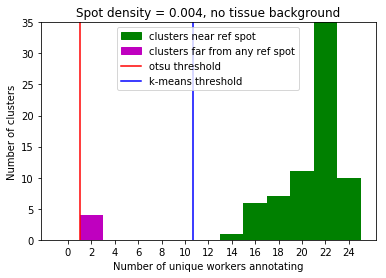

Using only clusters to the right of the k-means threshold:
TPR = 0.85
FPR = 0.06


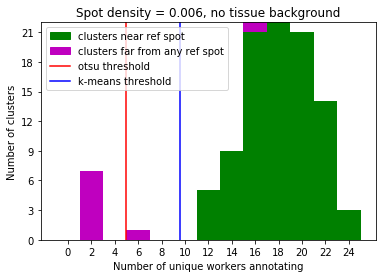

Using only clusters to the right of the k-means threshold:
TPR = 0.77
FPR = 0.06


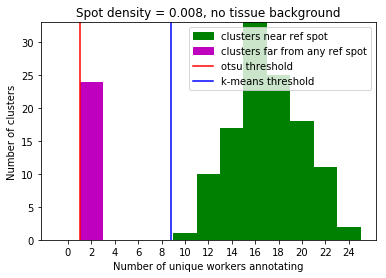

Using only clusters to the right of the k-means threshold:
TPR = 0.62
FPR = 0.18


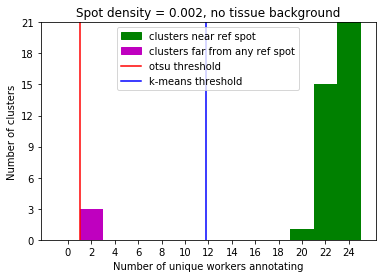

Using only clusters to the right of the k-means threshold:
TPR = 0.87
FPR = 0.08


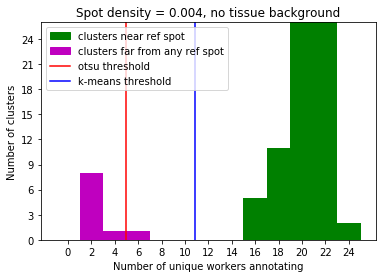

Using only clusters to the right of the k-means threshold:
TPR = 0.86
FPR = 0.04


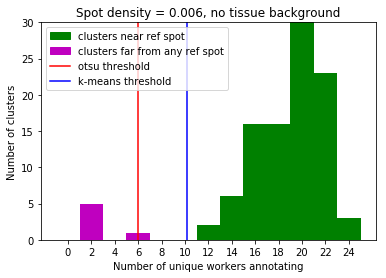

Using only clusters to the right of the k-means threshold:
TPR = 0.77
FPR = 0.06


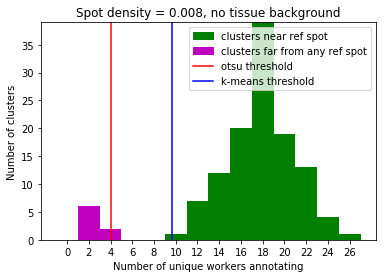

Using only clusters to the right of the k-means threshold:
TPR = 0.7
FPR = 0.06


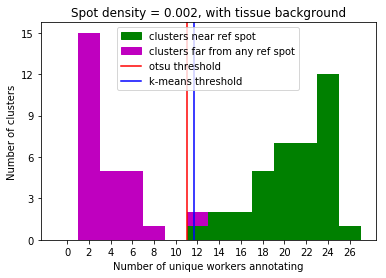

Using only clusters to the right of the k-means threshold:
TPR = 0.67
FPR = 0.3


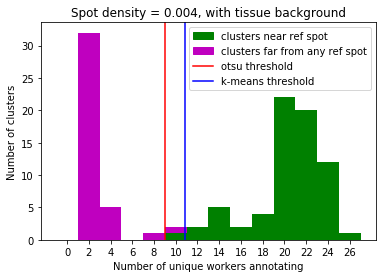

Using only clusters to the right of the k-means threshold:
TPR = 0.77
FPR = 0.12


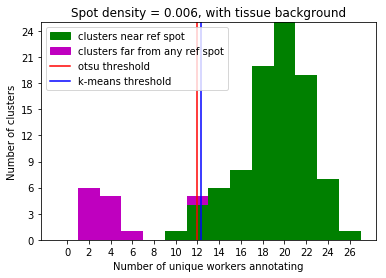

Using only clusters to the right of the k-means threshold:
TPR = 0.63
FPR = 0.14


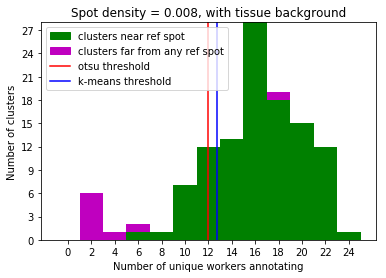

Using only clusters to the right of the k-means threshold:
TPR = 0.53
FPR = 0.06


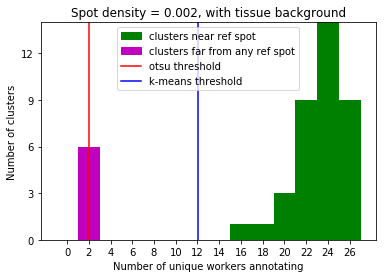

Using only clusters to the right of the k-means threshold:
TPR = 0.87
FPR = 0.08


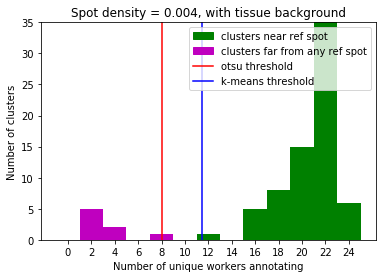

Using only clusters to the right of the k-means threshold:
TPR = 0.81
FPR = 0.1


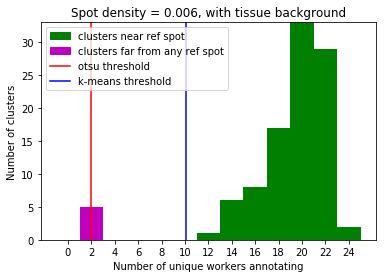

Using only clusters to the right of the k-means threshold:
TPR = 0.78
FPR = 0.05


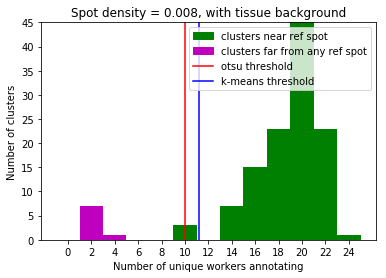

Using only clusters to the right of the k-means threshold:
TPR = 0.69
FPR = 0.06


In [2]:
json_filename_list = ['Spots_density_no_tissue.json','Spot_density.json']
density_list = [0.002, 0.004, 0.006, 0.008]
snr_mu_list = [5, 10]
TPR_list_no_tissue = []
FPR_list_no_tissue = []
TPR_list_with_tissue = []
FPR_list_with_tissue = []
for json_filename in json_filename_list:
    for snr_mu in snr_mu_list:
        for density in density_list:
            img_name = 'snr_' + str(snr_mu)+ '_0_density_' + str(density)
            if (json_filename == 'Spots_density_no_tissue.json'):
                img_filename = img_name+'_spots.png'
                img_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/density_test/spot_arrays/'+img_filename
            else:
                img_filename = img_name+'_spot_img.png'
                img_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/density_test/spot_images/'+img_filename
            csv_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/density_test/spot_data/'+img_name+'_coord_snr_list.csv'
            json_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/density_test/'+json_filename

            ba = QuantiusAnnotation(json_filepath)
            sa = SpotAnnotationAnalysis(ba)
            anno_all = ba.df()
            anno_one_image = ba.slice_by_image(anno_all, img_filename)

            # Find separation between clusters with few and many unique annotators. 
            plot_title = "Spot density = " + str(density) + ", "
            if (json_filename == 'Spots_density_no_tissue.json'):
                plot_title += 'no tissue background'
            else:
                plot_title += 'with tissue background'
            bigger_window_size = False
            sa.plot_annotations_per_cluster(anno_one_image, clustering_params, show_correctness, correctness_threshold, csv_filepath, img_filename, plot_title, bigger_window_size)

            clusters = sa.get_clusters(anno_one_image, clustering_params)
            total_num_clusters = len(clusters.index)
            threshold = sa.get_cluster_size_threshold(clusters)
            threshold = math.ceil(threshold)
            small_clusters, large_clusters = sa.sort_clusters_by_size_input_threshold(clusters, threshold)

            # Calculate and store detection rate (sensitivity: num_detected_actual_spots/num_actual_spots)
            # and false positive rate (error rate: num_detected_not_spots/all_detected_spots)
            num_detected_actual_spots = 0
            num_detected_not_spots = 0
            ref_kdt = sa.csv_to_kdt(csv_filepath, img_height)
            for i in range(len(large_clusters.index)):
                row = clusters.iloc[[i]]
                centroid_x = row.iloc[0]['centroid_x']
                centroid_y = row.iloc[0]['centroid_y']
                centroid_coord = [[centroid_x, centroid_y]]
                dist, ind = ref_kdt.query(centroid_coord, k=1)
                distance = dist[0][0]
                if (distance <= correctness_threshold):
                    num_detected_actual_spots += 1
                else:
                    num_detected_not_spots += 1
            num_actual_spots = len(pd.read_csv(csv_filepath).index)
            TPR = num_detected_actual_spots/num_actual_spots
            FPR = num_detected_not_spots/(num_detected_not_spots+num_detected_actual_spots)
            if (json_filename == 'Spots_density_no_tissue.json'):
                TPR_list_no_tissue.append(TPR)
                FPR_list_no_tissue.append(FPR)
            else:
                TPR_list_with_tissue.append(TPR)
                FPR_list_with_tissue.append(FPR)
            print("Using only clusters to the right of the k-means threshold:")
            print("TPR = " + str(round(TPR,2)))
            print("FPR = " + str(round(FPR,2)))

#### If we only pay attention to clusters with many unique annotators (to the right of the k-means line in the figure above), how do the sensitivity and error rate change with increased spot density?

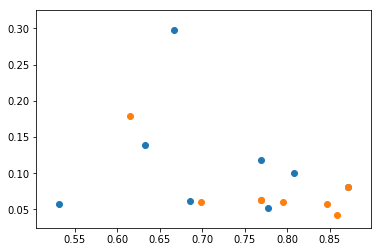

In [3]:
plt.scatter(TPR_list_with_tissue, FPR_list_with_tissue)
plt.scatter(TPR_list_no_tissue, FPR_list_no_tissue)